In [1]:
%load_ext autoreload
%autoreload 2

# Import matplotlib stuff FIRST, before Lightning
import pandas as pd
import torch
import matplotlib.pyplot as plt
%matplotlib inline

# Then import Lightning and other stuff
from pl_trainer import LightningModule
from data_module import MNISTDataModule
from torchvision import transforms
import torch.nn as nn
import lightning.pytorch as pl

pl.seed_everything(42)

Seed set to 42


42

# Setting up Hyperparameters

In [2]:
lr = 1.0 # Change learning rate here
batch_size = 64
max_epochs = 5

# Defining Model Architecture 

def create_model():
    """
        Initializes the model. Edit the code below if you would like to change the model.
    """
    model = nn.Sequential(
        nn.Flatten(),  # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
        nn.Linear(28*28*1, 10), 
        # Implement changes here
        # No need to include softmax, as this is already combined in the loss function
    )
    return model

# Initialize the model, data module, and trainer
pl_model = LightningModule(model = create_model(), lr=lr)

In [3]:
def create_model():
    """
        Initializes the model. Edit the code below if you would like to change the model.
    """
    model = nn.Sequential(
        nn.Flatten(),  # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
        nn.Linear(28*28*1, 64),
        # Implement changes here
        nn.ReLU(),
        nn.Linear(64, 10)
        # No need to include softmax, as this is already combined in the loss function
    )
    return model

pl_model = LightningModule(create_model(), lr=lr)

# Setting up Dataloaders and Transformations

In [4]:
my_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])


mnist_data = MNISTDataModule(batch_size=batch_size, transforms=my_transforms)

# Train Model

In [5]:
# Initialize CSVLogger
csv_logger = pl.loggers.CSVLogger(save_dir='logs/', name='mnist_logs', version=0)

# Set up the trainer
trainer = pl.Trainer(max_epochs=max_epochs, logger=csv_logger, check_val_every_n_epoch=1, enable_checkpointing=False)

# Train the model
trainer.fit(pl_model, mnist_data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Eirik\miniconda3\envs\viscomp\lib\site-packages\lightning\fabric\loggers\csv_logs.py:268: Experiment logs directory logs/mnist_logs\version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | model   | Sequential         | 50.9 K | train
1 | loss_fn | CrossEntropyLoss   | 0      | train
2 | acc_fn  | MulticlassAccuracy | 0      | train
-------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 25.64it/s]

c:\Users\Eirik\miniconda3\envs\viscomp\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


c:\Users\Eirik\miniconda3\envs\viscomp\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 937/937 [00:13<00:00, 69.24it/s, v_num=0, val_acc=0.113, val_loss=2.300] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 937/937 [00:13<00:00, 69.23it/s, v_num=0, val_acc=0.113, val_loss=2.300]


# Plot Results

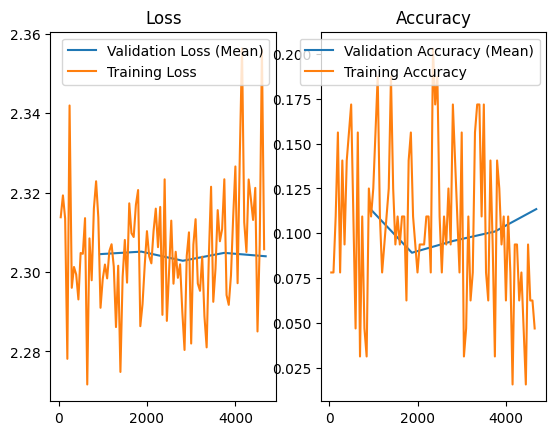

Final validation loss 2.304
Final validation accuracy 0.1135


In [6]:
df = pd.read_csv('logs/mnist_logs/version_0/metrics.csv')

# Create a figure and axes objects
fig, ax = plt.subplots(1, 2)

# Plot Loss - using ax.plot() instead of df.plot()
val_loss_df = df.dropna(subset=['val_loss'])
ax[0].plot(val_loss_df['step'], val_loss_df['val_loss'], label='Validation Loss (Mean)')

train_loss_df = df.dropna(subset=['train_loss'])
ax[0].plot(train_loss_df['step'], train_loss_df['train_loss'], label='Training Loss')

# Plot Accuracy - using ax.plot() instead of df.plot()
val_acc_df = df.dropna(subset=['val_acc'])
ax[1].plot(val_acc_df['step'], val_acc_df['val_acc'], label='Validation Accuracy (Mean)')

train_acc_df = df.dropna(subset=['train_acc'])
ax[1].plot(train_acc_df['step'], train_acc_df['train_acc'], label='Training Accuracy')

ax[0].set_title('Loss')
ax[0].legend()
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

print("Final validation loss", round(df['val_loss'].iloc[-1], 4))
print("Final validation accuracy", round(df['val_acc'].iloc[-1], 4))

hidden layer:
Final validation loss 0.1999
Final validation accuracy 0.9405

# Plot weights

In [22]:
def plot_weights(weight):
    """
        Plots the weights of the model. Only works for models with a single linear layer.
        returns the shape of the reshaped weights as torch.Size
    """

    fig, axs = plt.subplots(1, 10, figsize=(20, 2))

    
    reshaped_weight = weight.view(10, 28, 28) # TODO - Reshape the weight into the correct shape for MNIST
    
    
    for i in range(10):
        axs[i].imshow(reshaped_weight[i], cmap='viridis')
        axs[i].axis('off')
    #plt.show()
        
    return reshaped_weight.shape


weight = list(pl_model.model.children())[-1].state_dict()["weight"].cpu().data
print("Shape of weights:", weight.shape)
if weight.shape == torch.Size([10, 784]):
    plot_weights(weight)
else:
    print("This function only works for models with a single linear layer.")


Shape of weights: torch.Size([10, 64])
This function only works for models with a single linear layer.
